# Лекция 2. Случайный лес. Градиентный бустинг

In [1]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score,recall_score,accuracy_score

In [2]:
titanic = pd.read_csv('/content/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#предобработка
titanic['Sex']=titanic['Sex'].map({'male':1,'female':0})

#кодирование категориальных признаков [Pclass,Embarked]
def encode_features(df,features):
  df_encode = pd.DataFrame()
  for f in features:
    ohe = OneHotEncoder()
    ohe_arr = ohe.fit_transform(df[[f]])
    ohe_df=pd.DataFrame(ohe_arr.toarray(), columns=ohe.get_feature_names_out())
    df_encode = pd.concat([df_encode,ohe_df],axis=1)
  return df_encode
enc_features = encode_features(titanic,['Pclass','Embarked'])
titanic_df = titanic[['Survived','Sex','Age','SibSp','Parch','Fare']]
titanic_df = pd.concat([titanic_df,enc_features],axis=1)
titanic_df=titanic_df.drop([titanic_df.columns[-1]],axis=1).dropna()

In [4]:
#делим на X и Y
Y = titanic_df['Survived']
X = titanic_df.drop(['Survived'],axis=1)

# Случайный лес - Random Forest

Случайный лес – метод Машинного обучения (ML), использующий Ансамбль (Ensemble) Деревьев решений (Decision Tree) для задач Классификации (Classification). Каждое отдельное дерево в таком лесу дает предсказание класса, и набравший наибольшее количество голосов Класс (Class), становится предсказанием Модели (Model). Он использует Бэггинг (Bagging) и случайность признаков при построении каждого отдельного дерева, чтобы создать некоррелированный лес из деревьев, прогноз которого "комитетом" более точен, чем прогноз любого отдельного дерева.

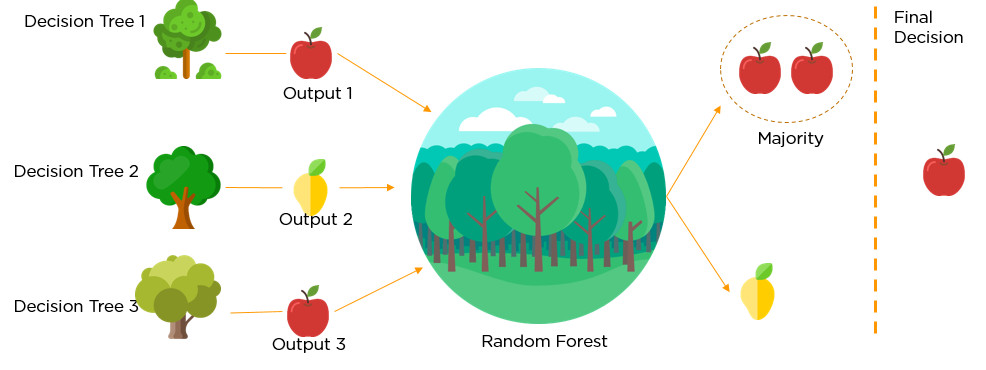

Фундаментальная концепция в основе случайного леса проста, но сильна — это мудрость толпы. Причина, по которой модель случайного леса работает так хорошо, заключается в том, что:

Большое число относительно некоррелированных деревьев, работающих совместно, будет превосходить любую из их отдельных составляющих.

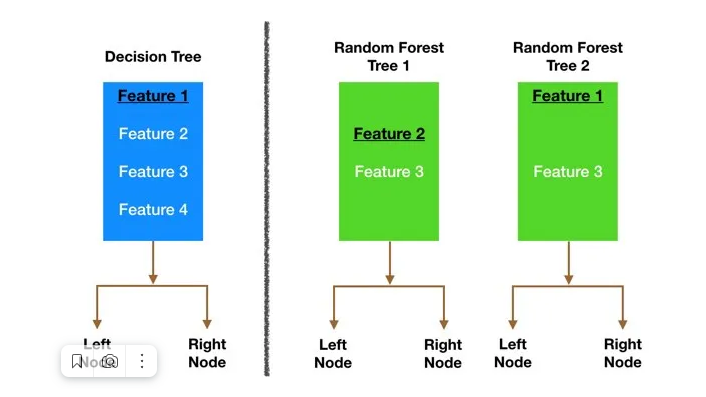

Случайность признака. В обычном дереве решений, когда нужно разделить узел, мы рассматриваем каждый возможный признак и выбираем тот, который сильнее делит значения в узлах. Напротив, каждое дерево в случайном лесу может выбирать только из случайного подмножества объектов. Это приводит к еще большей вариации между деревьями в модели и в конечном итоге к более слабой корреляции между деревьями и большему разнообразию.

Бэггинг. Деревья решений очень чувствительны к данным, на которых обучаются: небольшие изменения в наборе могут привести к значительно отличающимся древовидным структурам. Случайный лес использует это преимущество, позволяя каждому отдельному дереву произвольно выбирать данные с заменой, что приводит к различным деревьям. Этот процесс известен как беггинг.

In [5]:
#создание модели
model = RandomForestClassifier()

In [6]:
#тюнинг
n_estimators = [10, 100, 200] #количество деревьев
max_features = ['sqrt', 'log2',len(X.columns)]

In [7]:
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, Y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793584 using {'max_features': 'sqrt', 'n_estimators': 100}
0.782877 (0.045750) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.793584 (0.044550) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.787989 (0.040652) with: {'max_features': 'sqrt', 'n_estimators': 200}
0.780027 (0.036783) with: {'max_features': 'log2', 'n_estimators': 10}
0.781892 (0.045848) with: {'max_features': 'log2', 'n_estimators': 100}
0.791230 (0.044223) with: {'max_features': 'log2', 'n_estimators': 200}
0.789834 (0.046845) with: {'max_features': 11, 'n_estimators': 10}
0.790747 (0.043192) with: {'max_features': 11, 'n_estimators': 100}
0.788393 (0.039410) with: {'max_features': 11, 'n_estimators': 200}


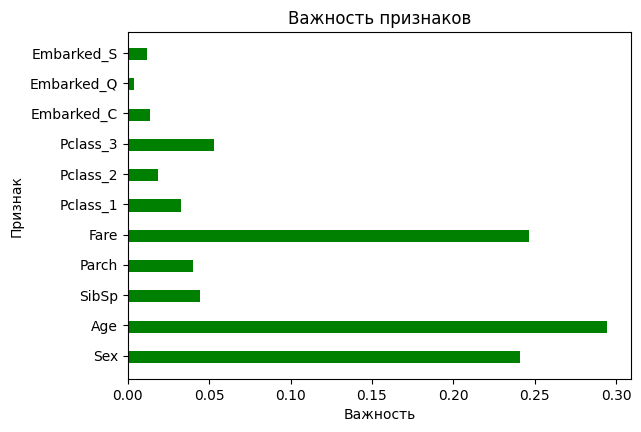

<Figure size 500x500 with 0 Axes>

In [ ]:
#важность признаков
model_rf = RandomForestClassifier(n_estimators=100,max_features='log2')
model_rf.fit(X,Y)
col = X.columns
y = model_rf.feature_importances_
fig, ax = plt.subplots()
width = 0.4
ind = np.arange(len(y))
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [ ]:
#из леса можно выдернуть каждое отдельное дерево и визуализировать его
estimator = model_rf.estimators_[5]

## Градиентный бустинг

Бустинг — это техника построения ансамблей, в которой предсказатели построены не независимо, а последовательно

Это техника использует идею о том, что следующая модель будет учится на ошибках предыдущей.

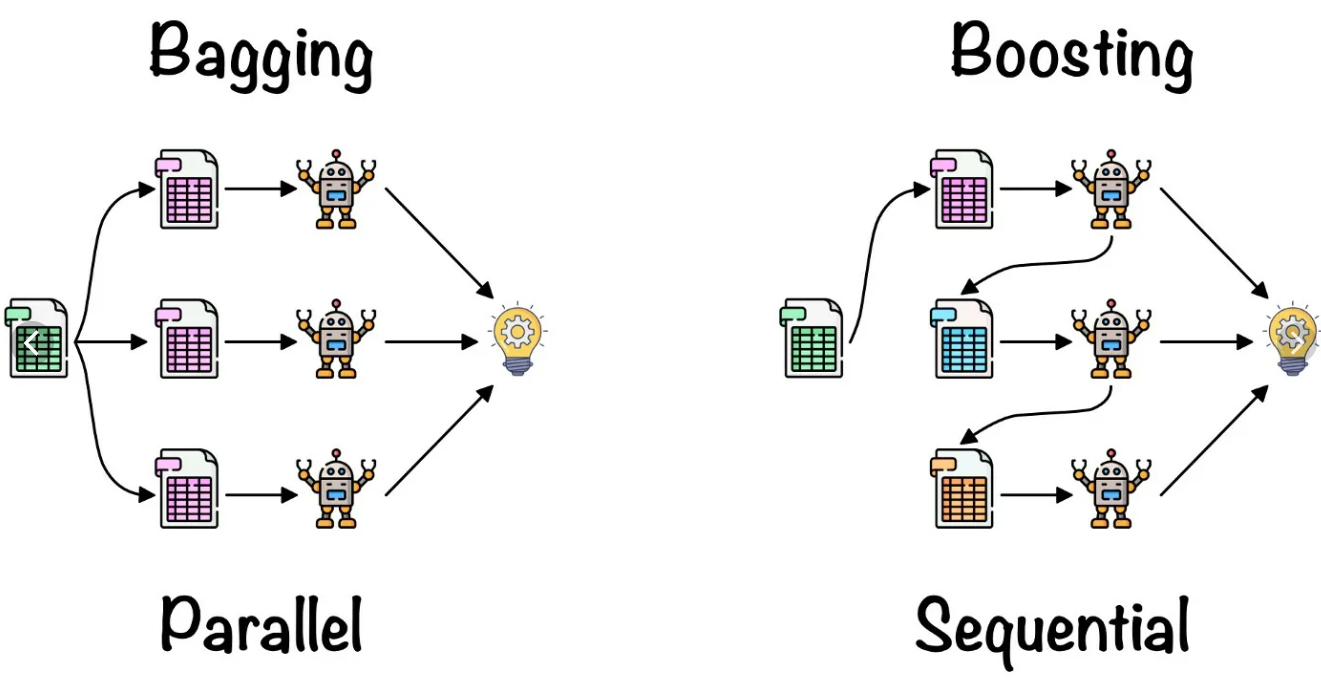

Градиентный бустинг — это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений.

In [ ]:
model = GradientBoostingClassifier()
n_estimators = [10, 50, 100]
learning_rate = [0.001, 0.01, 0.1] # скорость обучения каждого дерева
subsample = [0.5, 0.7, 1.0] #подвыборка
max_depth = [3, 7, 9] #глубина деревьев
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, Y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f , (%f) , with: %r" % (mean, stdev, param))

Best: 0.821101 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_dep

Также есть другие варианты реализации градиентного бустинга:
* XGBoost
* CatBoost

## CatBoost

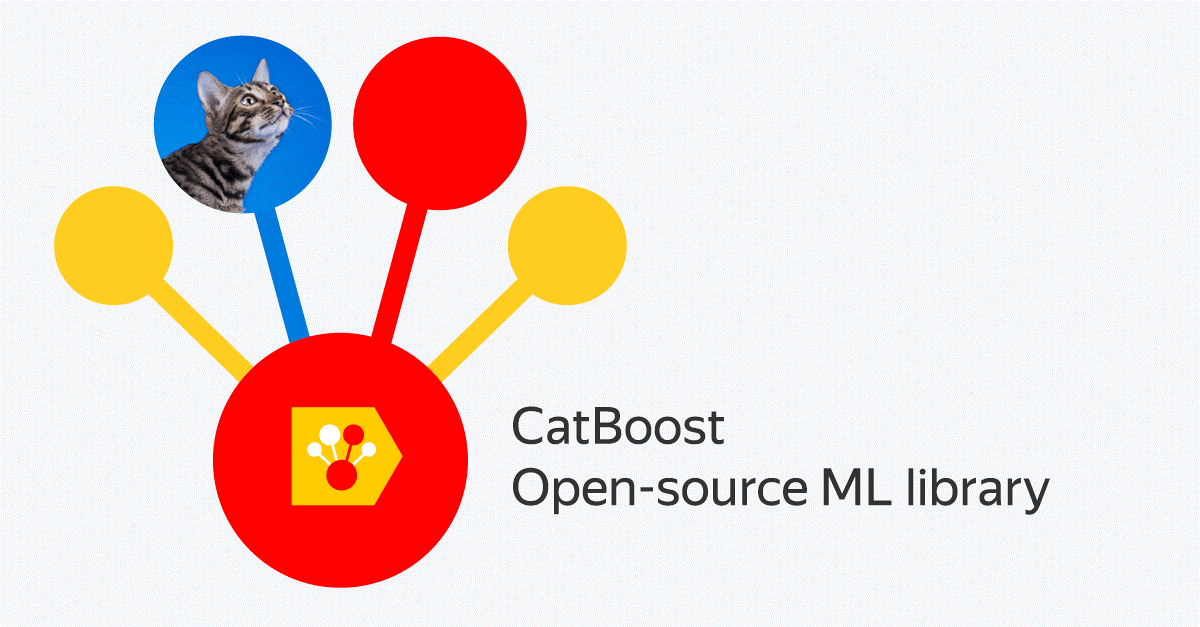

CatBoost (Categorical Boosting) — это алгоритм машинного обучения, разработанный компанией Яндекс. Он предназначен для работы с табличными данными и особенно эффективен в задачах, где важную роль играют категориальные признаки. Основной механизм работы CatBoost — градиентный бустинг на деревьях решений

Основные особенности CatBoost:
* Работа с категориальными признаками. CatBoost уникален благодаря своей способности обрабатывать категориальные данные без необходимости в предварительном кодировании. Это позволяет значительно упростить подготовку данных и сохранить информацию, которая может быть утрачена при использовании методов вроде one-hot encoding.
* Обработка пропусков. Алгоритм автоматически обрабатывает пропущенные значения, что уменьшает вероятность возникновения ошибок, связанных с отсутствием данных.
* Борьба с переобучением. CatBoost использует несколько методов для предотвращения переобучения, включая мощную регуляцию и усреднение.
* Скорость и производительность. В CatBoost реализованы оптимизации, делающие обучение и предсказания более быстрыми по сравнению с аналогами. Они включают в себя поддержку многоядерной обработки и эффективное использование памяти.
* Стабильность и воспроизводимость. Алгоритм предлагает методы, обеспечивающие стабильные результаты даже при изменении порядка входных данных.

CatBoost реализует улучшенный подход к градиентному бустингу, который включает в себя следующие этапы:

* Инициализация. Алгоритм начинается с простой модели, которая предсказывает среднее значение целевой переменной.
* Построение деревьев. На каждом шаге создаётся новое дерево решений, обучающееся на ошибках предыдущей модели. Деревья добавляются последовательно, при этом корректируются предсказания.
* Использование случайных перестановок. Для борьбы с переобучением CatBoost применяет метод случайных перестановок данных, что помогает улучшить обобщающую способность модели.
* Вычисление градиента. На каждой итерации вычисляется градиент ошибки, который затем используется для корректировки модели.
* Интеграция модели. Итоговое предсказание — это взвешенная сумма всех деревьев, где каждый последующий шаг уменьшает ошибку модели.

CatBoost выделяется среди других алгоритмов бустинга способностью эффективно работать с категориальными данными и предоставлять точные предсказания, минимизируя риск переобучения и обеспечивая высокую скорость обучения

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
titanic_cb = titanic[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].dropna()
titanic_cb.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


In [ ]:
X = titanic_cb.drop(['Survived'],axis=1)
Y = titanic_cb['Survived']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [ ]:
#выявим категориальные признаки
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['Embarked']

In [ ]:
#укажем набор категориальных признаков сами
cat_features = ['Embarked','Sex','Pclass']

Основные параметры для catboost
* learning_rate : этот параметр управляет размером шага или скоростью, с которой модель обновляет свои прогнозы во время каждой итерации повышения. Меньшая скорость обучения приводит к более медленной сходимости, но может помочь модели лучше обобщать. Обычный диапазон для скорости обучения составляет от 0,01 до 0,3.
* iterations : определяет количество итераций усиления или деревьев для построения. Каждая итерация добавляет новое дерево в ансамбль, а прогнозы модели обновляются на основе объединенных прогнозов всех деревьев. Увеличение количества итераций может улучшить производительность модели, но также может привести к переобучению.
* depth : этот параметр задает максимальную глубину отдельных деревьев в ансамбле. Более глубокое дерево может захватывать более сложные шаблоны, но также может привести к переобучению. Вам следует поэкспериментировать с различными значениями глубины, чтобы найти оптимальный баланс между сложностью модели и производительностью.
* loss_function : Параметр loss_function позволяет указать функцию потерь, используемую для оптимизации модели во время обучения. CatBoost поддерживает различные функции потерь, включая «Logloss» (бинарная классификация), «RMSE» (регрессия) и пользовательские функции потерь, которые вы можете определить на основе вашей конкретной проблемы.
* custom_metric : Вы можете использовать этот параметр для указания пользовательских метрик оценки, которые недоступны в наборе метрик по умолчанию, предоставляемых CatBoost. Например, если у вас есть конкретная метрика, которая важна для вашей проблемы, вы можете определить ее здесь для оценки модели.
* l2_leaf_reg : термин регуляризации L2 , применяемый к листовым значениям. Он помогает контролировать гладкость изученных листовых значений. Более высокие значения l2_leaf_reg приводят к более гладким листовым значениям, что может предотвратить переобучение.
* max_leaves : Этот параметр определяет максимальное количество листьев (конечных узлов) в каждом дереве. Ограничение максимального количества листьев может помочь контролировать сложность отдельных деревьев и уменьшить переобучение.

In [ ]:
model = CatBoostClassifier(iterations=100, depth=8, learning_rate=0.1, cat_features=cat_features,
                           loss_function='Logloss', custom_metric=['Accuracy'], random_seed=42)

In [ ]:
model.fit(X_train, Y_train, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6644336	total: 49.5ms	remaining: 4.9s
1:	learn: 0.6353186	total: 51.1ms	remaining: 2.5s
2:	learn: 0.6129457	total: 52ms	remaining: 1.68s
3:	learn: 0.5915915	total: 53.6ms	remaining: 1.29s
4:	learn: 0.5739333	total: 54.6ms	remaining: 1.04s
5:	learn: 0.5584352	total: 55.3ms	remaining: 866ms
6:	learn: 0.5460328	total: 55.7ms	remaining: 741ms
7:	learn: 0.5325533	total: 56.7ms	remaining: 652ms
8:	learn: 0.5226375	total: 57.3ms	remaining: 579ms
9:	learn: 0.5113877	total: 58.1ms	remaining: 523ms
10:	learn: 0.5025273	total: 60.7ms	remaining: 491ms
11:	learn: 0.4930488	total: 63.4ms	remaining: 465ms
12:	learn: 0.4828250	total: 65.5ms	remaining: 438ms
13:	learn: 0.4752437	total: 66.9ms	remaining: 411ms
14:	learn: 0.4680953	total: 68.3ms	remaining: 387ms
15:	learn: 0.4622047	total: 68.8ms	remaining: 361ms
16:	learn: 0.4560359	total: 70.9ms	remaining: 346ms
17:	learn: 0.4517265	total: 72.9ms	remaining: 332ms
18:	learn: 0.4456486	total: 74.4ms	remaining: 317ms
19:	learn: 0.4408538	total

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Sex,52.107029
1,Pclass,15.131193
2,Age,13.158667
3,Fare,10.682759
4,SibSp,5.781872
5,Parch,2.166754
6,Embarked,0.971725


Text(0.5, 1.0, 'Feature Importance')

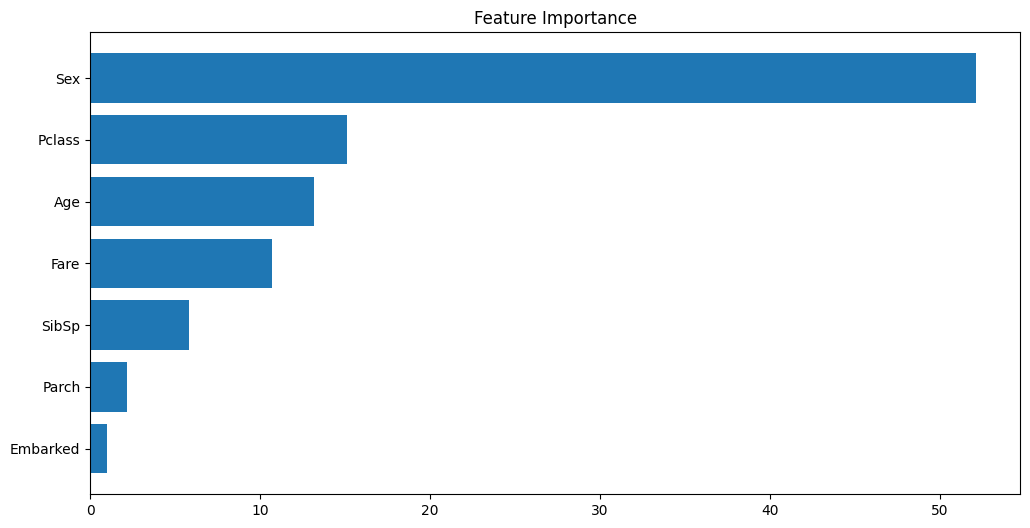

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
class_predictions = model.predict(X_test)
class_predictions.shape

In [ ]:
print('Accuracy - ',accuracy_score(class_predictions,Y_test))
print('Precision - ',precision_score(class_predictions,Y_test))
print('Recall - ',recall_score(class_predictions,Y_test))

## CatBoost в задаче регрессии

In [ ]:
X = titanic_cb.drop(['Fare'],axis=1)
Y = titanic_cb['Fare']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
569,1,3,1,32.0,0,0,S
572,1,1,1,36.0,0,0,S
685,0,2,1,25.0,1,2,C
40,0,3,0,40.0,1,0,S
399,1,2,0,28.0,0,0,S


In [ ]:
cat_features = ['Embarked','Sex','Pclass','Survived']

In [ ]:
#импорты из catboost
from catboost import CatBoostRegressor
model = CatBoostRegressor(loss_function='RMSE',
                              n_estimators=100,
                              max_depth=4,
                              learning_rate=0.1,
                              min_child_samples=1,
                              colsample_bylevel=0.9,
                              subsample=0.9,
                              random_seed=101,
                              cat_features=cat_features)

In [ ]:
model.fit(X_train, Y_train, verbose=True)

0:	learn: 50.3366039	total: 857us	remaining: 84.9ms
1:	learn: 48.7765695	total: 1.5ms	remaining: 73.7ms
2:	learn: 47.1457053	total: 2.11ms	remaining: 68.2ms
3:	learn: 45.7898607	total: 2.55ms	remaining: 61.2ms
4:	learn: 44.4403552	total: 3.02ms	remaining: 57.4ms
5:	learn: 43.4845829	total: 3.45ms	remaining: 54ms
6:	learn: 42.3935606	total: 4.08ms	remaining: 54.2ms
7:	learn: 41.6357137	total: 4.65ms	remaining: 53.5ms
8:	learn: 41.0117459	total: 5.24ms	remaining: 53ms
9:	learn: 40.1647003	total: 5.78ms	remaining: 52ms
10:	learn: 39.7187696	total: 6.28ms	remaining: 50.8ms
11:	learn: 39.2586868	total: 6.76ms	remaining: 49.6ms
12:	learn: 38.6545416	total: 7.23ms	remaining: 48.4ms
13:	learn: 38.2825658	total: 7.73ms	remaining: 47.5ms
14:	learn: 37.9564146	total: 8.19ms	remaining: 46.4ms
15:	learn: 37.5742637	total: 8.74ms	remaining: 45.9ms
16:	learn: 37.2408973	total: 9.19ms	remaining: 44.9ms
17:	learn: 36.9447322	total: 9.6ms	remaining: 43.7ms
18:	learn: 36.6819930	total: 10ms	remaining: 42

In [ ]:
#важность признаков
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Pclass,35.610781
1,Age,19.361788
2,Embarked,15.620382
3,Parch,12.154104
4,SibSp,6.890819
5,Sex,6.537619
6,Survived,3.824507


In [ ]:
y_predictions = model.predict(X_test)
y_predictions.shape

(143,)

In [ ]:
import plotly.graph_objects as go

random_x = np.linspace(0, len(y_predictions[:100]))

fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=Y_test[:100],
                    mode='lines',
                    name='истинные'))
fig.add_trace(go.Scatter(x=random_x, y=y_predictions[:100],
                    mode='lines+markers',
                    name='предсказанные'))
fig.show()

## ЛР CATBOOST

* найти набор данных, для которого МОЖНО РЕШИТЬ ЗАДАЧУ КЛАССИФИКАЦИИ ИЛИ РЕГРЕССИИ
* выполнить предобработку (если необходимо) и стандартизацию данных (любым способом)
* разделить набор данных на обучающую и тестовую выборки
* построить модель catboost
* выбрать метрику для оценки качества моделей
* оценить качество модели с помощью выбранной метрики на тестовой выборке
* построить вторую модель (отличную от первой), оценить её качество, выбрать лучшую модель
* для лучшей модели построить график важности признаков и сделать выводы о важности признаков